<a href="https://colab.research.google.com/github/rafaelnordavind/artigo-final/blob/main/06_Artigo_keras_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras

<ipython-input-1-a24c07ddc17f>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Baixando a base de dados do repositório do github
!mkdir dataset
!wget --no-check-certificate \
"https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_hour.csv" \
-O "dataset/df_max_requests_hour.csv"

mkdir: cannot create directory ‘dataset’: File exists
--2023-06-26 07:15:46--  https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_hour.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9754 (9.5K) [text/plain]
Saving to: ‘dataset/df_max_requests_hour.csv’

dataset/df_max_requ 100%[===================>]   9.53K  --.-KB/s    in 0s      

2023-06-26 07:15:46 (58.7 MB/s) - ‘dataset/df_max_requests_hour.csv’ saved [9754/9754]



In [3]:
data_df = pd.read_csv('dataset/df_max_requests_hour.csv', parse_dates=['timestamp'])
# Converte a coluna timestamp para o formato datetime
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
# Setando a coluna timestamp como indice
data_df.set_index('timestamp', inplace=True)
data_df.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,15
1995-08-28 01:00:00-04:00,19
1995-08-28 02:00:00-04:00,9
1995-08-28 03:00:00-04:00,10
1995-08-28 04:00:00-04:00,12


I am extracting the apple stocks only: AAPL

In [4]:
data_df.shape

(336, 1)

In [5]:
data_df.tail()

,num_requests
timestamp,
1995-09-10 19:00:00-04:00,32
1995-09-10 20:00:00-04:00,18
1995-09-10 21:00:00-04:00,28
1995-09-10 22:00:00-04:00,15
1995-09-10 23:00:00-04:00,23


In [6]:
data_df.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,15
1995-08-28 01:00:00-04:00,19
1995-08-28 02:00:00-04:00,9
1995-08-28 03:00:00-04:00,10
1995-08-28 04:00:00-04:00,12


In [7]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['num_requests'].values.reshape(-1, 1))

In [8]:
dataset[0:10]

array([[0.33333333],
       [0.42222222],
       [0.2       ],
       [0.22222222],
       [0.26666667],
       [0.28888889],
       [0.37777778],
       [0.26666667],
       [0.37777778],
       [0.35555556]])

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

235 101


In [10]:
print(len(data_df))

336


In [11]:
# convert an array of values into a dataset matrix
window_size = 6
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
x_train, y_train = create_dataset(train, look_back=window_size)
x_test, y_test = create_dataset(test, look_back=window_size)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(228, 6)
(228,)
(94, 6)
(94,)


In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(228, 1, 6)
(228,)
(94, 1, 6)
(94,)


In [16]:
# create and fit the LSTM network
from keras.layers import Bidirectional, Dropout
look_back = window_size
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.2))  # Adiciona camada de dropout com taxa de 0.2
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(
            x_train,
            y_train,
            #steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            validation_data=(x_test, y_test),
            verbose = 2,
            batch_size=10
            )
model.summary()

Epoch 1/20
23/23 - 8s - loss: 0.0923 - mae: 0.2566 - val_loss: 0.0441 - val_mae: 0.1567 - 8s/epoch - 352ms/step
Epoch 2/20
23/23 - 0s - loss: 0.0244 - mae: 0.1139 - val_loss: 0.0244 - val_mae: 0.1221 - 312ms/epoch - 14ms/step
Epoch 3/20
23/23 - 0s - loss: 0.0210 - mae: 0.1109 - val_loss: 0.0238 - val_mae: 0.1168 - 284ms/epoch - 12ms/step
Epoch 4/20
23/23 - 0s - loss: 0.0203 - mae: 0.1043 - val_loss: 0.0237 - val_mae: 0.1150 - 261ms/epoch - 11ms/step
Epoch 5/20
23/23 - 0s - loss: 0.0189 - mae: 0.1004 - val_loss: 0.0233 - val_mae: 0.1148 - 151ms/epoch - 7ms/step
Epoch 6/20
23/23 - 0s - loss: 0.0202 - mae: 0.1029 - val_loss: 0.0230 - val_mae: 0.1139 - 197ms/epoch - 9ms/step
Epoch 7/20
23/23 - 0s - loss: 0.0183 - mae: 0.0994 - val_loss: 0.0227 - val_mae: 0.1151 - 184ms/epoch - 8ms/step
Epoch 8/20
23/23 - 0s - loss: 0.0203 - mae: 0.1041 - val_loss: 0.0224 - val_mae: 0.1130 - 225ms/epoch - 10ms/step
Epoch 9/20
23/23 - 0s - loss: 0.0194 - mae: 0.1022 - val_loss: 0.0223 - val_mae: 0.1106 - 240

In [17]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 [==============================] - 0s 5ms/step
Train Score: 5.93 RMSE
Test Score: 6.43 RMSE


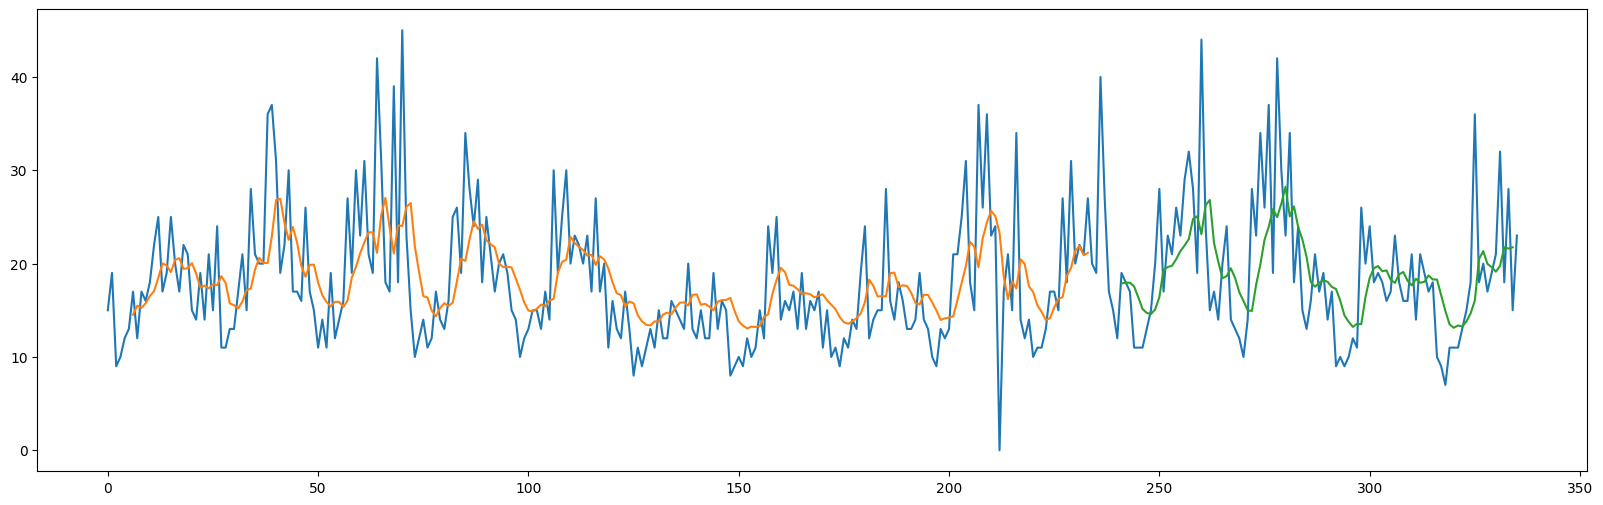

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

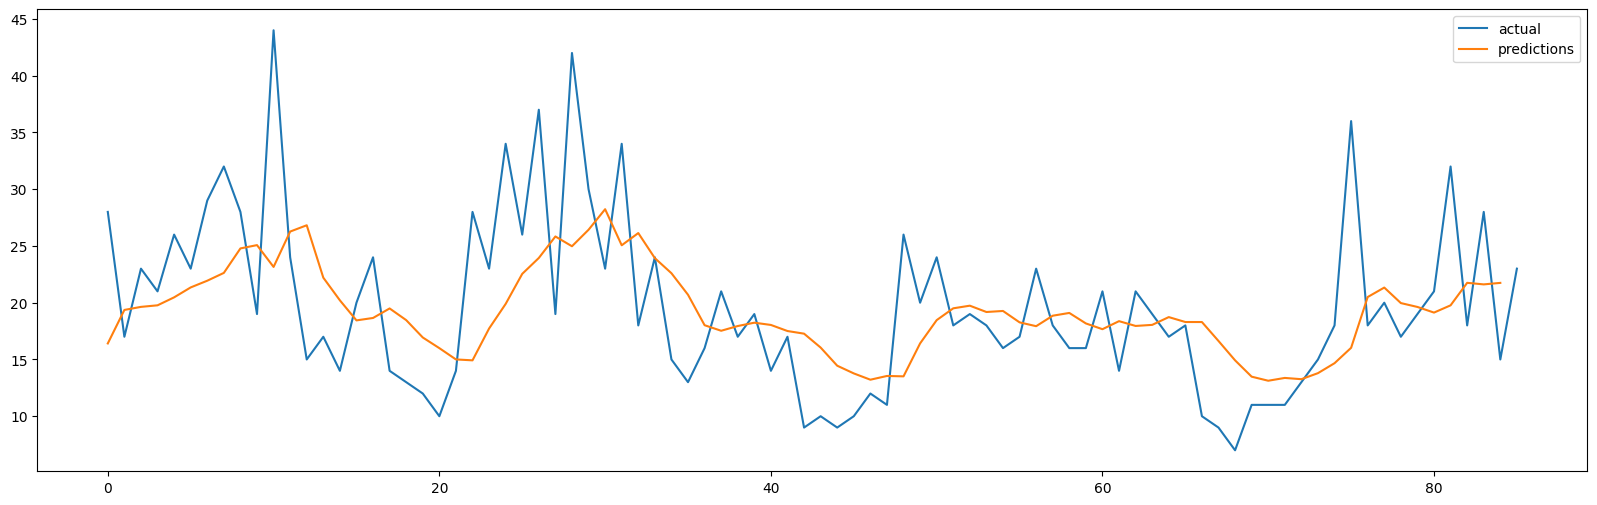

In [19]:
## visualize results
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset)[250:350], label = 'actual')
plt.plot(testPredictPlot[250:350], label = 'predictions')
plt.legend()

>reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


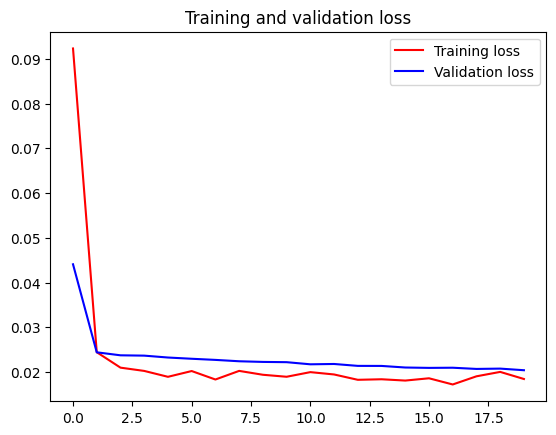

<Figure size 640x480 with 0 Axes>

In [20]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()